### **Notebook for analysing nf pipeline output**

#### ONT seq16-17

## Packages

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import glob, os, re
import matplotlib.pyplot as plt
from datetime import  datetime
from ipywidgets import widgets, interactive

In [2]:
dt = datetime.today().strftime(format='%d-%m-%Y')

### **Establish parent directory**

In [3]:
#uniqueness in directory and file names is assumed for all analyses
sars_dir = 'SARS-CoV-2'
run_dir = 'seq16-17_30-09-2021'
home_dir = os.getenv('HOME')
parent_dir = glob.glob(f'{home_dir}/**/{sars_dir}', recursive=True)[0]

## Functions

In [4]:
# define a func to replace spaces in the header names
def tidy_header(df):
    df.columns = [col.replace(' ', '_') for col in df.columns]
    return df

In [5]:
# define func to retrieve particular columns from a df (spaces in col names must be replaced with _ in the input col_list)
def get_cols(df, col_list):
    new_df = tidy_header(df)
    return new_df[col_list]

In [6]:
# define a function to replace from a dictionary ('key is what is to be replaced': 'value is the replacement')
def replace(string, substitutions):
    substrings = sorted(substitutions, key=len, reverse=True)
    regex = re.compile('|'.join(map(re.escape, substrings)))
    return regex.sub(lambda match: substitutions[match.group(0)], string)

In [7]:
# define function to merge variants and nextclade data
def merge_varNxt(df_var_cln, df_nxt_cln):
    return (df_var_cln.set_index('sample_name').merge(df_nxt_cln
          .set_index('seqName'), how='outer', left_index=True, right_index=True)
                 .reset_index().rename(columns={'index': 'sample_name'}))

In [8]:
# define function to merge pangolin and variants-nextclade data
def merge_pngVxt(df_png_cln, df_varNxt):
    return (df_png_cln.set_index('Sequence_name').merge(df_varNxt
        .set_index('sample_name'), how='outer', left_index=True, right_index=True)
            .reset_index().rename(columns={'index': 'Sequence_name'}))


In [9]:
# define function to merge metadata with cts data
def merge_rmdCts(df_rmd_cln, df_cts_cln):
    return (df_rmd_cln.set_index('S_NUM').merge(df_cts_cln.set_index('Sample_Name'), how='outer', left_index=True, right_index=True)
            .reset_index().rename(columns={'index': 'S_NUM'}))


In [10]:
# define function to merge metadata and seq data
def merge_vnpPmd(df_pngVxt, df_rmdCts):
    return (df_pngVxt.set_index('S_NUM')
            .merge(df_rmdCts.set_index('S_NUM'), how='left', left_index=True, right_index=True)
                 .reset_index().rename(columns={'index': 'S_NUM'}))

In [11]:
# define a function to retrieve MoC and all mutations for the s-gene
def get_mut_of_concern(ann_file_name, moc_list):

    def intersection(x, y):
        return list(set(x) & set(y))

    moc_list = moc_list
#     file_name = 'k-per-gene_variant_anns.tsv'
    df = ann_file_name[['sample_name','S']]

#     df = pd.read_table(f'{base_dir}/{file_name}')[['sample_name','S']]
    mutations = []
    moc = []
    sample_id = []
    for row in df.itertuples():
        if isinstance(row.S, str):
            sgene = row.S
        else: 
            sgene = str(row.S)
        substitutions = sgene.replace(' ', '').split(',')[1:-1]
        if len(moc_list) >= len(intersection(moc_list, substitutions)) > 0:
            intsct = intersection(moc_list, substitutions)
            sample_name = row.sample_name
            mutations.append(str(substitutions).replace("[", "").replace("]", "").replace("'", ""))
            moc.append(str(intsct).replace("[", "").replace("]", "").replace("'", ""))
            sample_id.append(sample_name)
        else: pass 
    df = pd.DataFrame({'Sample_ID': sample_id, 'Mut_of_Concern_(S)': moc, 'All_Mutations_(S)': mutations})
    df_fnl = df.assign(Sample_ID = df['Sample_ID'].apply(lambda x: x.split('.')[0]))
    return df_fnl

### Variants data

In [12]:
# import the collated file for all the snpEff outputs
df_var = pd.read_table(glob.glob(f'{parent_dir}/**/{run_dir}/var/k-per-gene_variant_anns.tsv', recursive=True)[0])
df_var_fnl = df_var#df_var.assign(sample_name = df_var['sample_name'].apply(lambda x: '_'.join(x.split('_')[:-1]) if (len(x.split('_')) > 2) else x.split('_')[0]))

In [13]:
glob.glob(f'{parent_dir}/**/var/k-per-gene_variant_anns.tsv', recursive=True)[0]

'/home/douso/SARS-CoV-2/ONTVCOut/seq16-17_30-09-2021/var/k-per-gene_variant_anns.tsv'

In [14]:
df_var_fnl.head()

,sample_name,num_vars,ORF1ab,ORF1a,S,ORF3a,ORF3b,E,M,ORF6,ORF7a,ORF7b,ORF8,N,ORF9a,ORF9b,ORF10
0,COVC18434,6,"E102Q, T265I, F924F, L4715L",NaN,D614G,P240L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,COVC18312,14,"L61L, E102Q, T265I, F924F, K3353R, K4176R, T4652I",NaN,"D80Y, S375S, D614G",Q57H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"P13S, R195K, P207T",NaN,NaN,NaN
2,COVC17912,16,"F924F, Q1009R, V3595V, L4715L, C5557F, I5747T,...",NaN,"D614G, P681H","W69S, A99S",NaN,NaN,"T9T, L57L",NaN,NaN,NaN,S69P,"T205I, L400L",NaN,NaN,NaN
3,COVC18101,15,"G82_M85delinsV, T265I, P309L, F924F, P2685P, L...",NaN,"L54F, G72G, D614G, V1264V","Q57H, T223I",NaN,NaN,NaN,NaN,NaN,NaN,NaN,R195K,NaN,NaN,NaN
4,COVC17750,12,"E102Q, T265I, F924F, K3353R, L4715L, I6677T",NaN,D614G,Q57H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"P13S, Q181K, R195K, P207T",NaN,NaN,NaN


### Nextclade data

In [15]:
# import Nextclade clade data
df_nxt = pd.read_table(glob.glob(f'{parent_dir}/**/{run_dir}/nxt/nxt.tsv', recursive=True)[0])

# retrieve cols seqName and clade (func get_cols replaces col name spaces with _)
cols = ['seqName', 'clade', 'totalMissing']
df_nxt_cln = get_cols(df_nxt, cols)
coverage = round(100 - (df_nxt_cln['totalMissing'] / 29903) * 100, 1)
# df_nxt_cln1 = df_nxt_cln.assign(seqName = df_nxt_cln['seqName'].apply(lambda x: '_'.join((x.split('.')[0]).split('_')[1:-1]) if (len(x.split('_')) > 2) else (x.split('_')[0])))
df_nxt_fnl = df_nxt_cln.assign(coverage = coverage).drop('totalMissing', axis=1)

In [16]:
df_nxt_fnl.head()

,seqName,clade,coverage
0,COVC17734,20C,91.4
1,COVC17732,20C,92.4
2,COVC17739,20C,97.2
3,COVC17742,20C,89.5
4,COVC17737,20C,91.5


### Pangolin data v.3.1.11 (2021-08-09) Ran: 28-08-2021

In [17]:
# import Pangolin lineage data
df_png = pd.read_csv(glob.glob(f'{parent_dir}/**/{run_dir}/png/png.csv', recursive=True)[0])
# base_dir_pango = '/home/ouso/nextclade_files/batch2/nextclade_files_04-04-2021_11:25'
# file_name_pango = 'consensus_pango.xlsx'

# df_png = pd.read_excel(f'{base_dir_pango}/{file_name_pango}')
months = {'January': 'Jan', 'February': 'Feb', 'March': 'Mar',
         'April': 'Apr', 'June': 'Jun', 'July': 'Jul', 'August': 'Aug',
          'September': 'Sep', 'October': 'Oct', 'November': 'Nov', 'December': 'Dec'}
# retrieve cols Sequence_name and Lineage (func get_cols replaces col names spaces with _)
cols = ['Sequence_name', 'Lineage', 'Scorpio_call']#, 'Most_common_countries']
df_png_cln = get_cols(tidy_header(df_png), cols)
df_png_fnl = df_png_cln#df_png_cln.assign(Sequence_name = df_png_cln['Sequence_name'].apply(lambda x: '_'.join(x.split('_')[:-1]) if (len(x.split('_')) > 2) else x.split('_')[0]))
# df_png_fnl = df_png_cln1.assign(Date_range=df_png_cln1['Date_range'].apply(lambda x: replace(x, months) if (isinstance(x, str)) else x))

In [18]:
df_png_fnl.head()

,Sequence_name,Lineage,Scorpio_call
0,COVC17734,B.1,NaN
1,COVC17732,B.1,NaN
2,COVC17739,B.1,NaN
3,COVC17742,B.1,NaN
4,COVC17737,B.1,NaN


# Metadata

In [19]:
# import raw metadata file
df_rmd_cln = pd.read_excel(glob.glob(f'{parent_dir}/**/Outputs/COVID19-results-merged-cln.xlsx', recursive=True)[0])

In [20]:
df_rmd_cln.head()

,S_NUM,AGE_YRS,GEND,OCCU,NAT,COUNT_RES,S_COUNT_RES,TRAV_HIST,TRAV_FROM,QUAR_PLACE,SYMPS,DT_SAM_COLL,DT_SAM_RECEP,RESULT,DT_CONF
0,COVC00001,35.0,F,Refugee,NaN,Garissa,Dadaab,No,NaN,NaN,NaN,NaT,NaT,Negative,2020-06-02
1,COVC00002,29.0,M,Refugee,NaN,Garissa,Dadaab,No,NaN,NaN,NaN,NaT,NaT,Negative,2020-06-02
2,COVC00003,50.0,M,Refugee,NaN,Garissa,Dadaab,No,NaN,NaN,NaN,NaT,NaT,Negative,2020-06-02
3,COVC00004,35.0,F,Casual,NaN,Garissa,Dadaab,No,NaN,NaN,NaN,NaT,NaT,Negative,2020-06-02
4,COVC00005,27.0,F,Refugee,NaN,Garissa,Dadaab,No,NaN,NaN,NaN,NaT,NaT,Negative,2020-06-02


### Ct data

In [21]:
# import Ct data from sheet2 of the metadata file
df_cts = pd.read_excel(glob.glob(f'{parent_dir}/Outputs/**/runsheet-cts.xlsx', recursive=True)[0])

In [22]:
df_cts.head()

,Sample_Name,Well_Position,Dt_Run,Ct_Mean
0,COVC00137,D9,2020-06-03 17:04:05,37.6
1,COVC00154,F2,2020-06-03 17:04:05,35.2
2,COVC00744,D1,2020-06-12 18:14:45,34.7
3,COVC00762,E7,2020-06-12 18:14:45,36.0
4,COVC00767,E12,2020-06-12 18:14:45,34.1


### **Combining data**

#### Merge Variants and Nextclade data

In [23]:
# merge the nextclade data to the pangolin data
df_varNxt = merge_varNxt(df_var_fnl, df_nxt_fnl)

In [24]:
df_varNxt.head()

,sample_name,num_vars,ORF1ab,ORF1a,S,ORF3a,ORF3b,E,M,ORF6,ORF7a,ORF7b,ORF8,N,ORF9a,ORF9b,ORF10,clade,coverage
0,COVC17732,17,"E102Q, T265I, F924F, K3353R, A3755A, L4715L",NaN,"D614G, Q1201K","Q57H, Y113Y",NaN,NaN,NaN,NaN,NaN,NaN,"A14T, V62L","P13S, R195K, P207T",NaN,NaN,"N25N, N25N",20C,92.4
1,COVC17734,17,"E102Q, T265I, F924F, K3353R, A3755A, L4715L, L...",NaN,D614G,"Q57H, Y113Y",NaN,NaN,NaN,NaN,NaN,NaN,"A14T, V62L","P13S, R195K, P207T",NaN,NaN,"N25N, N25N",20C,91.4
2,COVC17735,20,"L61L, E102Q, T265I, Y359Y, F924F, I2774del, K3...",NaN,"D80Y, L242_L244del, S375S, D614G",Q57H,NaN,NaN,NaN,NaN,NaN,NaN,P36P,"P13S, R195K, P207T, S318S",NaN,NaN,NaN,20C,94.2
3,COVC17737,16,"E102Q, T265I, F924F, K2649R, K3353R, L4458L, L...",NaN,"D614G, G798S","Q57H, P240L",NaN,NaN,NaN,NaN,NaN,NaN,R115L,"P13S, R195fs, P207T",NaN,NaN,NaN,20C,91.5
4,COVC17739,9,"T265I, K714K, F924F, L4715L",NaN,D614G,Q57H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"S186F, S187T, R195K",NaN,NaN,NaN,20C,97.2


#### Merge pango and var-nextclade data

In [25]:
# merge the variants-nextclade data to the pangolin data (prioritise pango - left join)
df_pngVxt = merge_pngVxt(df_png_fnl, df_varNxt)

In [26]:
df_pngVxt.head()

,Sequence_name,Lineage,Scorpio_call,num_vars,ORF1ab,ORF1a,S,ORF3a,ORF3b,E,...,ORF6,ORF7a,ORF7b,ORF8,N,ORF9a,ORF9b,ORF10,clade,coverage
0,COVC17732,B.1,NaN,17,"E102Q, T265I, F924F, K3353R, A3755A, L4715L",NaN,"D614G, Q1201K","Q57H, Y113Y",NaN,NaN,...,NaN,NaN,NaN,"A14T, V62L","P13S, R195K, P207T",NaN,NaN,"N25N, N25N",20C,92.4
1,COVC17734,B.1,NaN,17,"E102Q, T265I, F924F, K3353R, A3755A, L4715L, L...",NaN,D614G,"Q57H, Y113Y",NaN,NaN,...,NaN,NaN,NaN,"A14T, V62L","P13S, R195K, P207T",NaN,NaN,"N25N, N25N",20C,91.4
2,COVC17735,B.1,NaN,20,"L61L, E102Q, T265I, Y359Y, F924F, I2774del, K3...",NaN,"D80Y, L242_L244del, S375S, D614G",Q57H,NaN,NaN,...,NaN,NaN,NaN,P36P,"P13S, R195K, P207T, S318S",NaN,NaN,NaN,20C,94.2
3,COVC17737,B.1,NaN,16,"E102Q, T265I, F924F, K2649R, K3353R, L4458L, L...",NaN,"D614G, G798S","Q57H, P240L",NaN,NaN,...,NaN,NaN,NaN,R115L,"P13S, R195fs, P207T",NaN,NaN,NaN,20C,91.5
4,COVC17739,B.1,NaN,9,"T265I, K714K, F924F, L4715L",NaN,D614G,Q57H,NaN,NaN,...,NaN,NaN,NaN,NaN,"S186F, S187T, R195K",NaN,NaN,NaN,20C,97.2


In [27]:
df_pngVxt_cols = ['Sequence_name', 'Lineage', 'Scorpio call',
       'num_vars', 'ORF1ab', 'ORF1a', 'S', 'ORF3a', 'ORF3b', 'E', 'M', 'ORF6',
       'ORF7a', 'ORF7b', 'ORF8', 'N', 'ORF9a', 'ORF9b', 'ORF10', 'clade',
       'coverage']
df_pngVxt_cols_rename = ['S_NUM', 'LIN', 'SCORP_CALL',
       'N_VAR', 'ORF1ab', 'ORF1a', 'S', 'ORF3a', 'ORF3b', 'E', 'M', 'ORF6',
       'ORF7a', 'ORF7b', 'ORF8', 'N', 'ORF9a', 'ORF9b', 'ORF10', 'CLADE',
       'G_COV']
df_pngVxt.columns = df_pngVxt_cols_rename

#### Merge the metadata and Cts data

In [28]:
# merge metadata with cts data
df_rmdCts = merge_rmdCts(df_rmd_cln, df_cts).rename(columns={'Ct_Mean': 'AVG_Ct'})

In [29]:
df_rmdCts.head()

,S_NUM,AGE_YRS,GEND,OCCU,NAT,COUNT_RES,S_COUNT_RES,TRAV_HIST,TRAV_FROM,QUAR_PLACE,SYMPS,DT_SAM_COLL,DT_SAM_RECEP,RESULT,DT_CONF,Well_Position,Dt_Run,AVG_Ct
0,COVC00001,35.0,F,Refugee,NaN,Garissa,Dadaab,No,NaN,NaN,NaN,NaT,NaT,Negative,2020-06-02,NaN,NaT,NaN
1,COVC00002,29.0,M,Refugee,NaN,Garissa,Dadaab,No,NaN,NaN,NaN,NaT,NaT,Negative,2020-06-02,NaN,NaT,NaN
2,COVC00003,50.0,M,Refugee,NaN,Garissa,Dadaab,No,NaN,NaN,NaN,NaT,NaT,Negative,2020-06-02,NaN,NaT,NaN
3,COVC00004,35.0,F,Casual,NaN,Garissa,Dadaab,No,NaN,NaN,NaN,NaT,NaT,Negative,2020-06-02,NaN,NaT,NaN
4,COVC00005,27.0,F,Refugee,NaN,Garissa,Dadaab,No,NaN,NaN,NaN,NaT,NaT,Negative,2020-06-02,NaN,NaT,NaN


#### Merge sequence/var-nxt-png (pngVxt) and  processed metadata (rmdCts)

In [30]:
# merge processed metadata with seq data
df_vnpPmd = merge_vnpPmd(df_pngVxt, df_rmdCts)

In [31]:
df_vnpPmd.columns#shape#head()

Index(['S_NUM', 'LIN', 'SCORP_CALL', 'N_VAR', 'ORF1ab', 'ORF1a', 'S', 'ORF3a',
       'ORF3b', 'E', 'M', 'ORF6', 'ORF7a', 'ORF7b', 'ORF8', 'N', 'ORF9a',
       'ORF9b', 'ORF10', 'CLADE', 'G_COV', 'AGE_YRS', 'GEND', 'OCCU', 'NAT',
       'COUNT_RES', 'S_COUNT_RES', 'TRAV_HIST', 'TRAV_FROM', 'QUAR_PLACE',
       'SYMPS', 'DT_SAM_COLL', 'DT_SAM_RECEP', 'RESULT', 'DT_CONF',
       'Well_Position', 'Dt_Run', 'AVG_Ct'],
      dtype='object')

#### QC whether all samples sequenced had metadata

In [32]:
codes_fnl = set(df_vnpPmd['S_NUM'])
codes_metadata = set(df_rmdCts['S_NUM'])
codes_union = codes_fnl & codes_metadata
if codes_fnl - codes_union == {}:
    print('All the samples in the the analysis were in the pre-seq metadata')
else:
    print(f'The following samples may be lacking pre-seq metadata, please verify:\n{codes_fnl - codes_union}')
    

The following samples may be lacking pre-seq metadata, please verify:
{'COVC24454', 'COVC24463', 'COVC24465', 'COVC24458', 'COVC24471', 'COVC24457', 'COVC24464', 'COVC24452', 'COVC24461', 'COVC24456', 'COVC24462', 'COVC24459', 'COVC24474', 'COVC24455', 'COVC24451', 'COVC24453', 'COVC24473', 'DRC-SHUK', 'COVC24472', 'COVC24466'}


#### Re-order df_vnpPmd columns and export merged metadata and sequencing data

In [33]:
header_MS = ['S_NUM', 'AGE_YRS', 'GEND', 'OCCU', 'NAT', 'COUNT_RES', 'TRAV_HIST',
               'TRAV_FROM', 'QUAR_PLACE', 'SYMPS', 'DT_SAM_COLL', 'DT_SAM_RECEP', 'RESULT', 
               'DT_CONF', 'AVG_Ct', 'LIN', 'SCORP_CALL', 'CLADE', 'G_COV', 'N_VAR',
               'S', 'ORF1ab', 'ORF1a', 'ORF3a', 'ORF3b', 'E', 'M', 'ORF6', 'ORF7a', 'ORF7b', 
               'ORF8', 'N', 'ORF9a', 'ORF9b', 'ORF10']

In [34]:
header_policy = ['S_NUM', 'AGE_YRS', 'GEND', 'OCCU', 'NAT', 'COUNT_RES', 'TRAV_HIST',
               'TRAV_FROM', 'QUAR_PLACE', 'SYMPS', 'DT_SAM_COLL', 'DT_SAM_RECEP', 'RESULT', 
               'DT_CONF', 'AVG_Ct']

In [35]:
df_ont_nodup = pd.read_excel(glob.glob(f'{parent_dir}/**/no_duplicate_ont_17-09-2021.xlsx', recursive=True)[0])
df_ont_nodup_ids = df_ont_nodup['sample_id'].tolist()

In [36]:
len(df_ont_nodup_ids)

214

In [37]:
df_vnpPmd_fnl = df_vnpPmd[header_policy]
df_vnpPmd_fnl = df_vnpPmd_fnl[df_vnpPmd_fnl['S_NUM'].isin(df_ont_nodup_ids) == True]
(df_vnpPmd_fnl.sort_values('S_NUM').drop_duplicates('S_NUM')
.to_excel(f"{glob.glob(f'{parent_dir}/**/KnowledgeBrief', recursive=True)[0]}/policy-brief-M-seq16-17_{dt}.xlsx"
                     , index=False, na_rep='N/A', float_format='%.1f'))

In [38]:
df_vnpPmd_fnl = df_vnpPmd[header_MS]
df_vnpPmd_fnl = df_vnpPmd_fnl[df_vnpPmd_fnl['S_NUM'].isin(df_ont_nodup_ids) == True]
(df_vnpPmd_fnl.sort_values('S_NUM').drop_duplicates('S_NUM')
.to_excel(f"{glob.glob(f'{parent_dir}/**/KnowledgeBrief', recursive=True)[0]}/metadata-seq-MS-seq16-17_{dt}.xlsx"
                     , index=False, na_rep='NA', float_format='%.1f'))
# df_vnpPmd_fnl.head()

### **Feedback Data**

### CDC VoI

In [39]:
gamma = ['L18F', 'T20N', 'P26S', 'D138Y', 'R190S', 'K417T', 'E484K', 'N501Y', 'D614G', 'H655Y', 'T1027I']
delta = ['T19R', '(V70F*)', 'T95I', 'G142D', 'E156-', 'F157-', 'R158G', '(A222V*)', '(W258L*)', '(K417N*)', 
         'L452R', 'T478K', 'D614G', 'P681R', 'D950N']
beta = ['D80A', 'D215G', '241del', '242del', '243del', 'K417N', 'E484K', 'N501Y', 'D614G', 'A701V']
alpha = ['69del', '70del', '144del', '(E484K*)', '(S494P*)', 'N501Y', 'A570D', 'D614G', 'P681H', 'T716I', 'S982A', 'D1118H', '(K1191N*)']

### CDC VoC

In [40]:
B16173 = ['T19R', 'G142D', 'L452R', 'E484Q', 'D614G', 'P681R', 'D950N']
kappa = ['(T95I)', 'G142D', 'E154K', 'L452R', 'E484Q', 'D614G', 'P681R', 'Q1071H']
iota = ['L5F', '(D80G*)', 'T95I', '(Y144-*)', '(F157S*)', 'D253G', '(L452R*)', '(S477N*)', 
        'E484K', 'D614G', 'A701V', '(T859N*)', '(D950H*)', '(Q957R*)']
eta = ['A67V', '69del', '70del', '144del', 'E484K', 'D614G', 'Q677H', 'F888L']

In [41]:
x = (set(gamma).union(set(delta)).union(set(beta)).union(set(alpha))).union(set(B16173).union(set(kappa)).union(set(iota)).union(set(eta)))
# x

### Variants of Concern or under investigation
 - N501Y (B.1.1.7): UK variant (Alpha)
 - N501Y, E484K, *K417N (B.1.351): SA variant (Beta)
 - N501Y, E484K (P.1): Brazilian variant (Gamma)
 - P681R, E484Q, L452R (B.1.617.2): *Indian variant (Delta)
 - F157L, V367F, Q613H, P681R (A23.1): Ugandan
 - E484K, Q677H, F888L (B.1.525): Multiple (Eta)
 - L5F, T95I, D253G, A701V (B.1.526): USA (Iota)
 - G142D, E154K, Q1071H ('B.1.617.1'): Indian (Kappa)

In [42]:
# MOH mutations of concern (spike only)
moc_list = ['N501Y', 'E484K', 'K417N', 'P681R', 'E484Q', 'L452R', 'A570D', 'D80A', 'Q677H', 'F888L', 'L5F', 'D253G', 'E154K', 'A67V']
file_name = df_var_fnl
df_moc = get_mut_of_concern(file_name, moc_list)

In [43]:
df_moc.head()

,Sample_ID,Mut_of_Concern_(S),All_Mutations_(S)
0,COVC17953,N501Y,N501Y
1,COVC18558,E484Q,"E484Q, D614G"
2,COVC18559,E484Q,E484Q
3,COVC24301,P681R,"T478K, D614G, P681R, D950N"
4,COVC24299,P681R,"P681R, D950N"


### Subsample brief data

In [44]:
#reorder columns and shrink data
cols = ['S_NUM', 'G_COV', 'DT_SAM_COLL', 'DT_SAM_RECEP', 'LIN', 'CLADE', 'SCORP_CALL', 'COUNT_RES'
        , 'GEND', 'NAT']

### Filter reporting coverage

In [45]:
df_brief = df_vnpPmd[cols][df_vnpPmd[cols]['G_COV'] >= 70]

In [46]:
df_brief.head()

,S_NUM,G_COV,DT_SAM_COLL,DT_SAM_RECEP,LIN,CLADE,SCORP_CALL,COUNT_RES,GEND,NAT
0,COVC17732,92.4,2020-10-30,2020-11-03,B.1,20C,NaN,Kiambu,F,Kenya
1,COVC17734,91.4,2020-10-31,2020-11-03,B.1,20C,NaN,Kiambu,F,Kenya
2,COVC17735,94.2,2020-10-31,2020-11-03,B.1,20C,NaN,Nairobi,M,Kenya
3,COVC17737,91.5,2020-10-31,2020-11-03,B.1,20C,NaN,Kiambu,M,Kenya
4,COVC17739,97.2,2020-10-31,2020-11-03,B.1,20C,NaN,Kiambu,M,Kenya


#### Merge df_brief with df_moc

In [47]:
df_brfMoc = (df_brief.merge(df_moc, how='left', left_on='S_NUM', right_on='Sample_ID'))
df_brfMoc_fnl = (df_brfMoc.fillna('N/A')
                 .loc[df_brfMoc['S_NUM'] != 'Undetermined']# removes "undetermined"
                 .drop(['Sample_ID', 'All_Mutations_(S)'], axis=1)
                 .drop_duplicates('S_NUM', ignore_index=True))

### Policy brief report

#### Rename report columns

In [48]:
cols = ['Sequence Name', 'coverage', 'Date Collection (dd-mm-yyyy)', 'Date Received (dd-mm-yyyy)', 'Pango Lineage Annotation', 'Next Clade Lineage Annotation', 'WHO Annotation','Sample County of Origin', 'Gender', 'Subject Country of Origin', 'MoC-S-Protein']
df_brfMoc_fnl.columns = cols

In [49]:
df_brfMoc_fnl.head()

,Sequence Name,coverage,Date Collection (dd-mm-yyyy),Date Received (dd-mm-yyyy),Pango Lineage Annotation,Next Clade Lineage Annotation,WHO Annotation,Sample County of Origin,Gender,Subject Country of Origin,MoC-S-Protein
0,COVC17732,92.4,2020-10-30 00:00:00,2020-11-03 00:00:00,B.1,20C,N/A,Kiambu,F,Kenya,N/A
1,COVC17734,91.4,2020-10-31 00:00:00,2020-11-03 00:00:00,B.1,20C,N/A,Kiambu,F,Kenya,N/A
2,COVC17735,94.2,2020-10-31 00:00:00,2020-11-03 00:00:00,B.1,20C,N/A,Nairobi,M,Kenya,N/A
3,COVC17737,91.5,2020-10-31 00:00:00,2020-11-03 00:00:00,B.1,20C,N/A,Kiambu,M,Kenya,N/A
4,COVC17739,97.2,2020-10-31 00:00:00,2020-11-03 00:00:00,B.1,20C,N/A,Kiambu,M,Kenya,N/A


In [50]:
def format_dates(x):
    if isinstance(x, pd.Timestamp):
        return x#x = x.strftime(format='%d-%m-%Y')
    return x
    

In [51]:
df_brfMoc_fnl['Date Collection (dd-mm-yyyy)'] = (df_brfMoc_fnl['Date Collection (dd-mm-yyyy)']
                                                 .map(lambda x: pd.NaT if (x == 'Nil') else format_dates(pd
                                                      .to_datetime(x, errors='coerce', dayfirst=True))))

In [52]:
df_brfMoc_fnl['Date Received (dd-mm-yyyy)'] = (df_brfMoc_fnl['Date Received (dd-mm-yyyy)']
                                                 .map(lambda x: pd.NaT if (x == 'Nil') else format_dates(pd
                                                      .to_datetime(x, errors='coerce', dayfirst=True))))

In [53]:
# df_report_fnl = df_brfMoc_fnl[df_brfMoc_fnl['Sequence Name'].str.contains('KEMRI') == False]

In [54]:
df_report_fnl = df_brfMoc_fnl

In [55]:
df_report_fnl.head()

,Sequence Name,coverage,Date Collection (dd-mm-yyyy),Date Received (dd-mm-yyyy),Pango Lineage Annotation,Next Clade Lineage Annotation,WHO Annotation,Sample County of Origin,Gender,Subject Country of Origin,MoC-S-Protein
0,COVC17732,92.4,2020-10-30,2020-11-03,B.1,20C,N/A,Kiambu,F,Kenya,N/A
1,COVC17734,91.4,2020-10-31,2020-11-03,B.1,20C,N/A,Kiambu,F,Kenya,N/A
2,COVC17735,94.2,2020-10-31,2020-11-03,B.1,20C,N/A,Nairobi,M,Kenya,N/A
3,COVC17737,91.5,2020-10-31,2020-11-03,B.1,20C,N/A,Kiambu,M,Kenya,N/A
4,COVC17739,97.2,2020-10-31,2020-11-03,B.1,20C,N/A,Kiambu,M,Kenya,N/A


In [56]:
df_report_fnl.to_excel(f"{glob.glob(f'{parent_dir}/**/KnowledgeBrief', recursive=True)[0]}/policy-brief-T-seq16-17_{dt}.xlsx"
                     , index=False, na_rep='N/A', float_format='%.1f')

In [57]:
#clrs = pd.read_html('https://www.rapidtables.com/web/css/css-color.html')

In [58]:
df_report_fnl.sort_values('Date Collection (dd-mm-yyyy)')#.head()

,Sequence Name,coverage,Date Collection (dd-mm-yyyy),Date Received (dd-mm-yyyy),Pango Lineage Annotation,Next Clade Lineage Annotation,WHO Annotation,Sample County of Origin,Gender,Subject Country of Origin,MoC-S-Protein
154,DRC-BKV-5073,90.5,2020-06-07,2021-08-02,B.1.214.2,20A,N/A,Bukavu,M,Democratic Republic of the Congo,N/A
148,DRC-BKV-219,92.5,2020-07-23,2021-08-02,B.1.351,"20H (Beta, V2)",Beta (B.1.351-like),Bukavu,M,Democratic Republic of the Congo,K417N
18,COVC17810,95.2,2020-10-02,2020-11-03,B.1,20C,N/A,Nairobi,F,Kenya,N/A
17,COVC17792,94.4,2020-10-02,2020-11-03,B.1,20C,N/A,Murang'a,F,Kenya,N/A
16,COVC17784,93.7,2020-10-02,2020-11-03,B.1,20C,N/A,Kiambu,M,Kenya,N/A
...,...,...,...,...,...,...,...,...,...,...,...
157,DRC-BKV-77,88.3,NaT,2021-08-02,B.1.617.2,21A (Delta),Delta (B.1.617.2-like),Bukavu,M,Democratic Republic of the Congo,P681R
158,DRC-BKV-882,92.2,NaT,2021-08-02,B.1.617.2,21A (Delta),Delta (B.1.617.2-like),Bukavu,N/A,Democratic Republic of the Congo,"P681R, L452R"
159,DRC-BKV-883,90.4,NaT,2021-08-02,B.1.617.2,21A (Delta),Delta (B.1.617.2-like),Bukavu,M,Democratic Republic of the Congo,"P681R, L452R"
160,DRC-BKV-906,92.2,NaT,2021-08-02,B.1.617.2,21A (Delta),Delta (B.1.617.2-like),Bukavu,M,Democratic Republic of the Congo,"P681R, L452R"


In [59]:
(df_report_fnl['Sample County of Origin']
 .value_counts())

Kiambu      65
N/A         23
Bukavu      19
Nyamira     18
Laikipia    18
Nairobi      6
Homabay      5
Migori       4
Murang'a     2
Kajiado      1
Machakos     1
Name: Sample County of Origin, dtype: int64

In [60]:
clr_code = {'TBA48': ('lime', '#00FF00'),
 'TBA01': ('gray', '#808080'),
 'TBA02': ('orangered', '#FF4500'),
 'TBA03': ('cyan', '#00FFFF'),
 'TBA05': ('chocolate', '#D2691E'),
 'TBA07': ('teal', '#008080'),
 'TBA09': ('slategray', '#708090'),
 'TBA11': ('orange', '#FFA500'),
 'TBA13': ('seagreen', '#2E8B57'),
 'TBA15': ('olive', '#808000'),
 'TBA17': ('honeydew', '#FFD700'),
 'TBA19': ('gold', '#8FBC8F'),
 'TBA24': ('aquamarine', '#006400'),
 'TBA25': ('yellowgreen', '#9ACD32'),
 'TBA26': ('tan', '#D2B48C'),
 'TBA27': ('indigo', '#4B0082'),
 'TBA28': ('mediumpurple', '#9370DB'),
 'TBA29': ('blue', '#0000FF'),
 'TBA30': ('darkslateblue', '#483D8B'),
 'TBA31': ('sienna', '#A0522D'),#'TBA32': ('darkkhaki', '#BDB76B'),
 'TBA33': ('khaki', '#F0E68C'),
 'TBA34': ('dodgerblue', '#1E90FF'),
 'TBA35': ('palevioletred', '#DB7093'),
 'TBA36': ('yellow', '#FFFF00'),
 'TBA37': ('floralwhite', '#6495ED'),
 'TBA38': ('green', '#008000'),
 'TBA39': ('red', '#AFEEEE'),
 'TBA40': ('purple', '#800080'),
 'TBA41': ('brown', '#A52A2A'),
 'TBA42': ('chocolate', '#D2691E'),
 'TBA43': ('steelblue', '#4682B4'),
 'TBA44': ('magenta', '#FF00FF'),
 'TBA45': ('rosybrown', '#BC8F8F'),
 'TBA46': ('goldenrod', '#DAA520'),
 'TBA47': ('paleturquoise', '#FF0000'),
 'TBA10': ('lavender', '#E6E6FA'),
 'TBA12': ('pink', '#FFC0CB'),
 'TBA14': ('seashell', '#FFFAF0'),
 'TBA16': ('mediumvioletred', '#C71585'),
 'TBA18': ('black', '#000000'),#'TBA2': ('cornflowerblue', '#FFF5EE'),
 'TBA20': ('saddlebrown', '#8B4513'),
 'TBA21': ('wheat', '#F5DEB3'),
 'TBA22': ('slategray', '#708090'),
 'TBA23': ('silver', '#C0C0C0'),
 'TBA04': ('midnightblue', '#191970'),
 'TBA06': ('darkgreen', '#7FFFD4'),
 'TBA08': ('darkseagreen', '#F0FFF0')}#BLUES NEXT B.1.361
avail_clr = list(clr_code.keys())

In [61]:
grpby_lins = (df_report_fnl.groupby('Pango Lineage Annotation')
        .count().sort_values('coverage', ascending=False))

In [62]:
max_count = grpby_lins['Sequence Name'].max()

In [63]:
clr_code_keys = list(clr_code.keys())

In [64]:
lins = list(grpby_lins.index)

In [65]:
lin_tba =  set(lins) - set(clr_code_keys)
lin_tba

{'A.23.1',
 'AY.16',
 'AY.24',
 'AY.27',
 'AY.4',
 'AY.5',
 'B.1',
 'B.1.1',
 'B.1.1.519',
 'B.1.214.2',
 'B.1.214.3',
 'B.1.351',
 'B.1.390',
 'B.1.393',
 'B.1.530',
 'B.1.540',
 'B.1.549',
 'B.1.574',
 'B.1.577',
 'B.1.596.1',
 'B.1.617.2'}

In [66]:
print(f'length of lins to be assigned: {len(lin_tba)}')
print(f'length of colours available: {len(avail_clr)}')

length of lins to be assigned: 21
length of colours available: 47


In [67]:
lin_clrs = {}
for z in zip(lins, avail_clr):
#     print(z)
    lin_clrs[z[0]] = clr_code[z[1]][1]
#     clr_code.pop(z[1])
#     avail_clr.remove(z[1])
# lin_clrs

In [68]:
import pprint
# pprint.pprint(clr_code)
# pprint.pprint(avail_clr)
pprint.pprint(lin_clrs)

{'A.23.1': '#8FBC8F',
 'AY.16': '#FF4500',
 'AY.24': '#FFD700',
 'AY.27': '#D2B48C',
 'AY.4': '#808080',
 'AY.5': '#708090',
 'B.1': '#00FF00',
 'B.1.1': '#006400',
 'B.1.1.519': '#9ACD32',
 'B.1.214.2': '#FFA500',
 'B.1.214.3': '#008080',
 'B.1.351': '#4B0082',
 'B.1.390': '#9370DB',
 'B.1.393': '#0000FF',
 'B.1.530': '#2E8B57',
 'B.1.540': '#808000',
 'B.1.549': '#483D8B',
 'B.1.574': '#A0522D',
 'B.1.577': '#F0E68C',
 'B.1.596.1': '#D2691E',
 'B.1.617.2': '#00FFFF'}


In [69]:
#updated colour code
clr_code

{'TBA48': ('lime', '#00FF00'),
 'TBA01': ('gray', '#808080'),
 'TBA02': ('orangered', '#FF4500'),
 'TBA03': ('cyan', '#00FFFF'),
 'TBA05': ('chocolate', '#D2691E'),
 'TBA07': ('teal', '#008080'),
 'TBA09': ('slategray', '#708090'),
 'TBA11': ('orange', '#FFA500'),
 'TBA13': ('seagreen', '#2E8B57'),
 'TBA15': ('olive', '#808000'),
 'TBA17': ('honeydew', '#FFD700'),
 'TBA19': ('gold', '#8FBC8F'),
 'TBA24': ('aquamarine', '#006400'),
 'TBA25': ('yellowgreen', '#9ACD32'),
 'TBA26': ('tan', '#D2B48C'),
 'TBA27': ('indigo', '#4B0082'),
 'TBA28': ('mediumpurple', '#9370DB'),
 'TBA29': ('blue', '#0000FF'),
 'TBA30': ('darkslateblue', '#483D8B'),
 'TBA31': ('sienna', '#A0522D'),
 'TBA33': ('khaki', '#F0E68C'),
 'TBA34': ('dodgerblue', '#1E90FF'),
 'TBA35': ('palevioletred', '#DB7093'),
 'TBA36': ('yellow', '#FFFF00'),
 'TBA37': ('floralwhite', '#6495ED'),
 'TBA38': ('green', '#008000'),
 'TBA39': ('red', '#AFEEEE'),
 'TBA40': ('purple', '#800080'),
 'TBA41': ('brown', '#A52A2A'),
 'TBA42': ('ch

In [70]:
def replace_with_who_lin(x):
    if x == 'B.1.1.7':
        return x.replace(x, 'B.1.1.7(Alpha)')
    elif x == 'B.1.617.2':
        return x.replace(x, 'B.1.617.2(Delta)')
    elif x == 'B.1.351':
        return x.replace(x, 'B.1.351(Beta)')
    elif x == 'B.1.525':
        return x.replace(x, 'B.1.525(Eta)')
    elif x == 'AY.4':
        return x.replace(x, 'AY.4(Delta)')
    elif x == 'AY.12':
        return x.replace(x, 'AY.12(Delta)')
    return x
    

In [71]:
xlabels = list(map(replace_with_who_lin,list(grpby_lins.sort_index().index)))

In [72]:
lins = (df_report_fnl.groupby('Pango Lineage Annotation').count()
 .coverage.sort_index())

In [73]:
lins.index=xlabels

In [74]:
lins.sort_values(ascending=False)

B.1                 68
AY.4(Delta)         26
AY.16               20
B.1.617.2(Delta)    13
B.1.596.1           11
B.1.214.3            3
AY.5                 2
B.1.214.2            2
B.1.530              2
B.1.540              2
AY.24                2
A.23.1               2
B.1.1                1
B.1.1.519            1
AY.27                1
B.1.351(Beta)        1
B.1.390              1
B.1.393              1
B.1.549              1
B.1.574              1
B.1.577              1
Name: coverage, dtype: int64

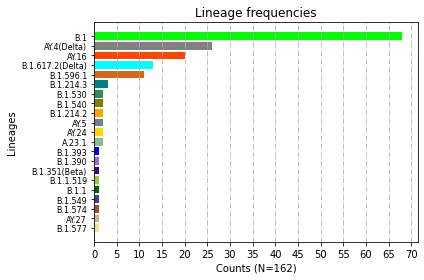

In [75]:
import math
# plot lineage frequencies
width = lins.sort_values(ascending=True)

colors = [lin_clrs[lin.split('(')[0]] for lin in list(width.index)]
# colors = [clr[1] for clr in clr_code.values()]
n = lins.sum()
xticks = np.arange(0, (math.ceil(max_count / 5) + 1) * 5, 5)
fig, ax = plt.subplots()
# (df_report_fnl['Pango Lineage Annotation']
#  .value_counts()
#  .sort_values(ascending=False)
plt.barh(width.index, width, color=colors)
plt.title('Lineage frequencies')
plt.ylabel('Lineages')
plt.xticks(xticks, xticks)
plt.yticks(width.index, fontsize=8)
plt.xlabel(f'Counts (N={n})')
plt.grid('major', axis='x', ls='-.')
plt.tight_layout()
# fig.savefig('/home/douso/SarsGenomics/Processed/policy-brief-P-ONTh.png')
plt.show()

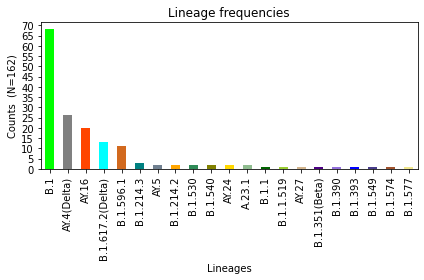

In [76]:
import math
# plot lineage frequencies
width = lins.sort_values(ascending=False)

colors = [lin_clrs[lin.split('(')[0]] for lin in list(width.index)]
n = df_report_fnl['Pango Lineage Annotation'].count()
yticks = np.arange(0, (math.ceil(max_count / 5) + 1) * 5, 5)
fig, ax = plt.subplots()
# (df_report_fnl['Pango Lineage Annotation']
#  .value_counts().
width.plot(kind='bar', ax=ax, color=colors)
plt.title('Lineage frequencies')
plt.xlabel('Lineages')
plt.yticks(yticks)
plt.xticks(ticks=range(len(lins)), rotation=90, labels=width.index)
plt.ylabel(f'Counts  (N={n})')
plt.tight_layout()
# fig.savefig('/home/douso/SarsGenomics/Processed/policy-brief-P-ONT.png')
plt.show()

In [77]:
df_report_fnl

,Sequence Name,coverage,Date Collection (dd-mm-yyyy),Date Received (dd-mm-yyyy),Pango Lineage Annotation,Next Clade Lineage Annotation,WHO Annotation,Sample County of Origin,Gender,Subject Country of Origin,MoC-S-Protein
0,COVC17732,92.4,2020-10-30,2020-11-03,B.1,20C,N/A,Kiambu,F,Kenya,N/A
1,COVC17734,91.4,2020-10-31,2020-11-03,B.1,20C,N/A,Kiambu,F,Kenya,N/A
2,COVC17735,94.2,2020-10-31,2020-11-03,B.1,20C,N/A,Nairobi,M,Kenya,N/A
3,COVC17737,91.5,2020-10-31,2020-11-03,B.1,20C,N/A,Kiambu,M,Kenya,N/A
4,COVC17739,97.2,2020-10-31,2020-11-03,B.1,20C,N/A,Kiambu,M,Kenya,N/A
...,...,...,...,...,...,...,...,...,...,...,...
157,DRC-BKV-77,88.3,NaT,2021-08-02,B.1.617.2,21A (Delta),Delta (B.1.617.2-like),Bukavu,M,Democratic Republic of the Congo,P681R
158,DRC-BKV-882,92.2,NaT,2021-08-02,B.1.617.2,21A (Delta),Delta (B.1.617.2-like),Bukavu,N/A,Democratic Republic of the Congo,"P681R, L452R"
159,DRC-BKV-883,90.4,NaT,2021-08-02,B.1.617.2,21A (Delta),Delta (B.1.617.2-like),Bukavu,M,Democratic Republic of the Congo,"P681R, L452R"
160,DRC-BKV-906,92.2,NaT,2021-08-02,B.1.617.2,21A (Delta),Delta (B.1.617.2-like),Bukavu,M,Democratic Republic of the Congo,"P681R, L452R"


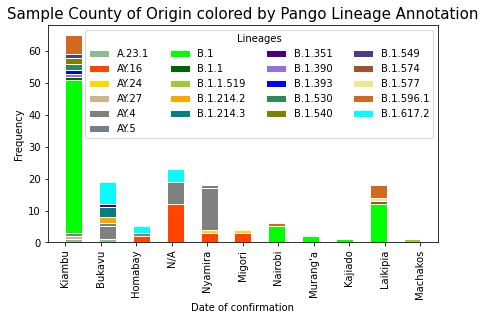

In [78]:
# Prepare data
df = df_report_fnl[df_report_fnl['Pango Lineage Annotation'].isin(['Failed', 'Unkown']) == False]

x_var = 'Sample County of Origin'
groupby_var = 'Pango Lineage Annotation'
df_agg = df[[x_var, groupby_var]].groupby(groupby_var)
vals = [d[x_var].values.tolist() for i, d in df_agg]

colors = {i: lin_clrs[i] for i, df in df_agg}
# Draw
plt.figure(figsize=(7,4))
# colors = [plt.cm.Spectral(i/float(len(vals)-1)) for i in range(len(vals))]
n, bins, patches = plt.hist(vals, len(df_agg[x_var].unique()), stacked=True, density=False, color=colors.values(), ec='w')

# Decoration
plt.legend(colors, title='Lineages', ncol=4)
plt.title(f"{x_var} colored by {groupby_var}", fontsize=15)
plt.xlabel('Date of confirmation')
plt.ylabel("Counts")
# plt.ylim(0, 40)
plt.xticks(rotation=90)
plt.show()